# U-net: Saved Model Visualisation

## Loading and exploration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib
tf.test.gpu_device_name()
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 794531406392751430
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14619377664
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 412737472136063999
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
!pip install openpyxl

In [ ]:
data = pd.read_csv('/content/bus_data.csv')

In [ ]:
data.head()

,ID,Case,Histology,Pathology,BIRADS,Device,Width,Height,Side,BBOX
0,bus_0001-l,1,invasive ductal carcinoma,malignant,4,GE Logiq 7 @10-14MHz,274,353,left,"[91,24,103,79]"
1,bus_0001-r,1,invasive ductal carcinoma,malignant,4,GE Logiq 7 @10-14MHz,275,353,right,"[102,24,82,79]"
2,bus_0002-l,2,fibroadenoma,benign,4,GE Logiq 7 @10-14MHz,274,371,left,"[134,142,88,50]"
3,bus_0002-r,2,fibroadenoma,benign,4,GE Logiq 7 @10-14MHz,276,371,right,"[113,143,68,47]"
4,bus_0003-l,3,invasive ductal carcinoma,malignant,4,GE Logiq 7 @10-14MHz,275,372,left,"[71,78,126,137]"


In [ ]:
data.shape

(1875, 10)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1875 entries, 0 to 1874
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         1875 non-null   object
 1   Case       1875 non-null   int64 
 2   Histology  1875 non-null   object
 3   Pathology  1875 non-null   object
 4   BIRADS     1875 non-null   int64 
 5   Device     1875 non-null   object
 6   Width      1875 non-null   int64 
 7   Height     1875 non-null   int64 
 8   Side       1875 non-null   object
 9   BBOX       1875 non-null   object
dtypes: int64(4), object(6)
memory usage: 146.6+ KB


In [ ]:
data.describe()

,Case,BIRADS,Width,Height
count,1875.000000,1875.000000,1875.000000,1875.000000
mean,517.461333,3.237333,321.310400,391.289600
std,307.787481,0.973882,76.917971,52.873259
min,1.000000,2.000000,240.000000,268.000000
25%,255.500000,2.000000,276.000000,350.000000
50%,497.000000,3.000000,286.000000,383.000000
75%,786.500000,4.000000,323.000000,435.000000
max,1064.000000,5.000000,579.000000,478.000000


In [ ]:
categorical_columns = ['Histology', 'Pathology', 'BIRADS', 'Side']

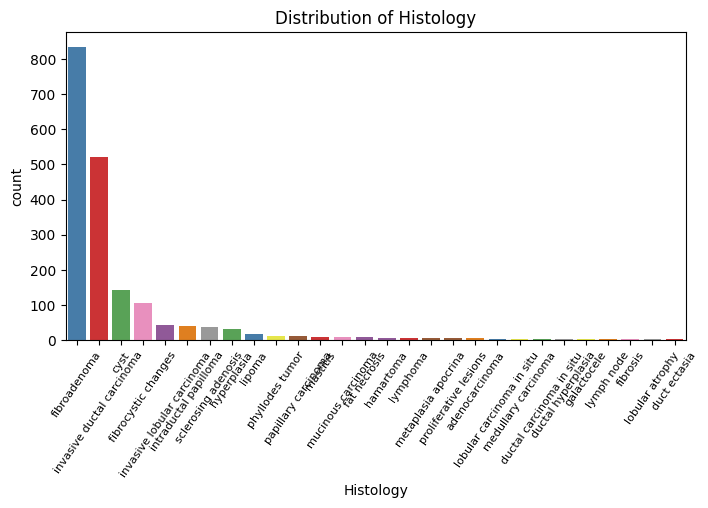

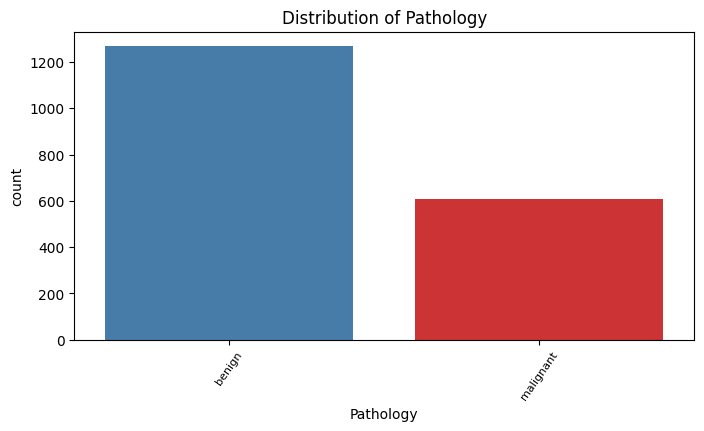

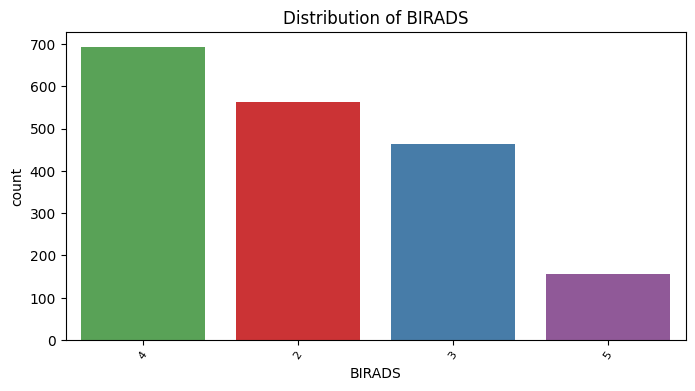

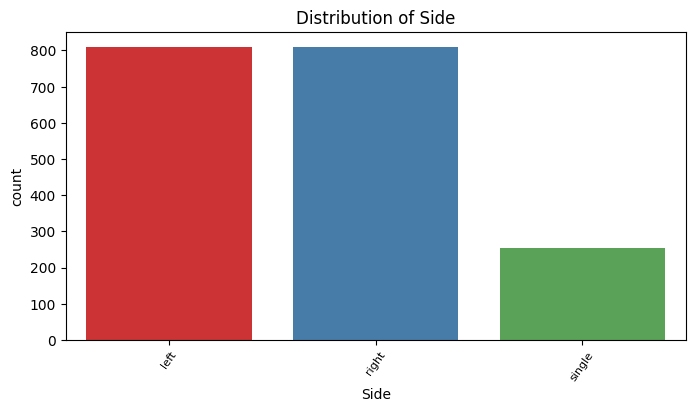

In [ ]:
def plot_categorical_distribution(column):
    plt.figure(figsize=(8, 4))
    sns.countplot(data=data, x=column, hue=column, order=data[column].value_counts().index, palette='Set1', legend=False)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=55, fontsize=8)
    plt.show()

for col in categorical_columns:
    plot_categorical_distribution(col)


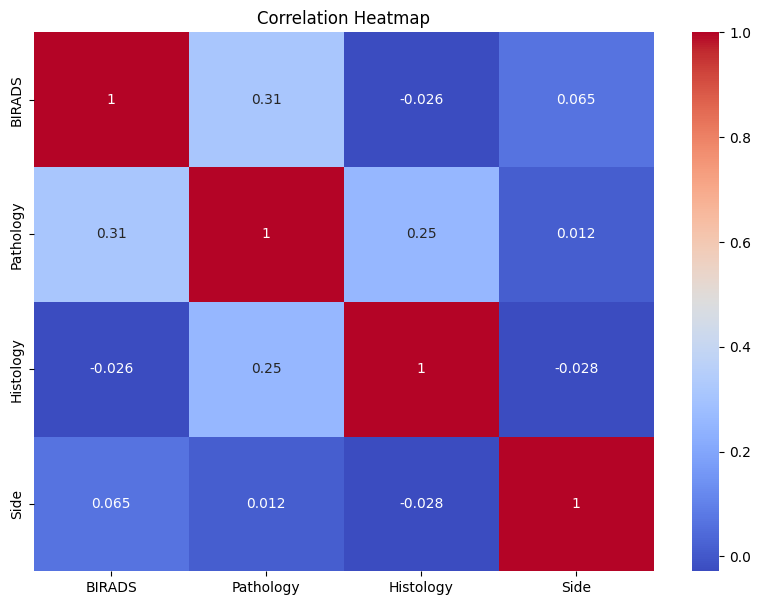

In [ ]:
plt.figure(figsize=(10, 7))
selected_columns = ['BIRADS', 'Pathology', 'Histology', 'Side']
sns.heatmap(data[selected_columns].apply(lambda x: pd.factorize(x)[0]).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
isMalignant = data[data['Pathology'] == 'malignant']
print("Malignant: ",len(isMalignant))
isBenign = data[data['Pathology'] == 'benign']
print("Benign: ",len(isBenign))

Malignant:  607
Benign:  1268


## Model

### Preprocessing

In [ ]:
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
labels = data['Pathology']

In [ ]:
le = LabelEncoder()

In [ ]:
y = le.fit_transform(labels)
y

array([1, 1, 0, ..., 1, 0, 0])

In [ ]:
len(y)

1875

In [ ]:


print(y[-10:])


[0 1 0 0 1 1 1 1 0 0]


## Visualizing U-Net's segmentation results

In [ ]:
from google.colab import drive
import os

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir("/content/drive/My Drive/Breast Cancer Stuff/BUS-BRA_dataset/Images")

In [ ]:
os.chdir("/content/drive/My Drive/BUS-BRA_dataset/Images")

In [ ]:
import random

image_dir = "/content/drive/My Drive/BUS-BRA_dataset/Images"
mask_dir = "/content/drive/My Drive/BUS-BRA_dataset/Masks"

image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

selected_images = random.sample(image_files, 10)

In [ ]:
import cv2

def visualize_segmentation(image, true_mask, pred_mask):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    # Original Image
    ax[0].imshow(image.squeeze(), cmap="gray")
    ax[0].set_title("Original Ultrasound")
    # True Mask (Ground Truth)
    ax[1].imshow(true_mask.squeeze(), cmap="viridis")
    ax[1].set_title("Ground Truth Mask")
    # Predicted Mask Overlay
    ax[2].imshow(image.squeeze(), cmap="gray")
    ax[2].imshow(pred_mask.squeeze(), alpha=0.3, cmap="jet")
    ax[2].set_title("Predicted Segmentation")
    plt.show()

In [ ]:
def dice_score(y_true, y_pred):
    smooth = 1e-6
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

In [ ]:
from tensorflow import keras
unet_model = keras.models.load_model('/content/saved_unet_model.keras', custom_objects={'dice_score': dice_score})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


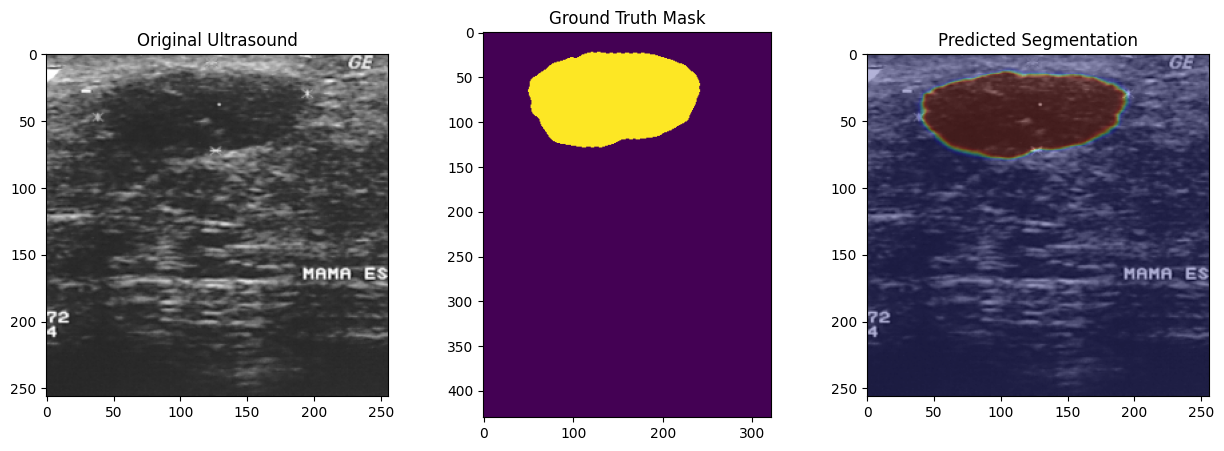

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


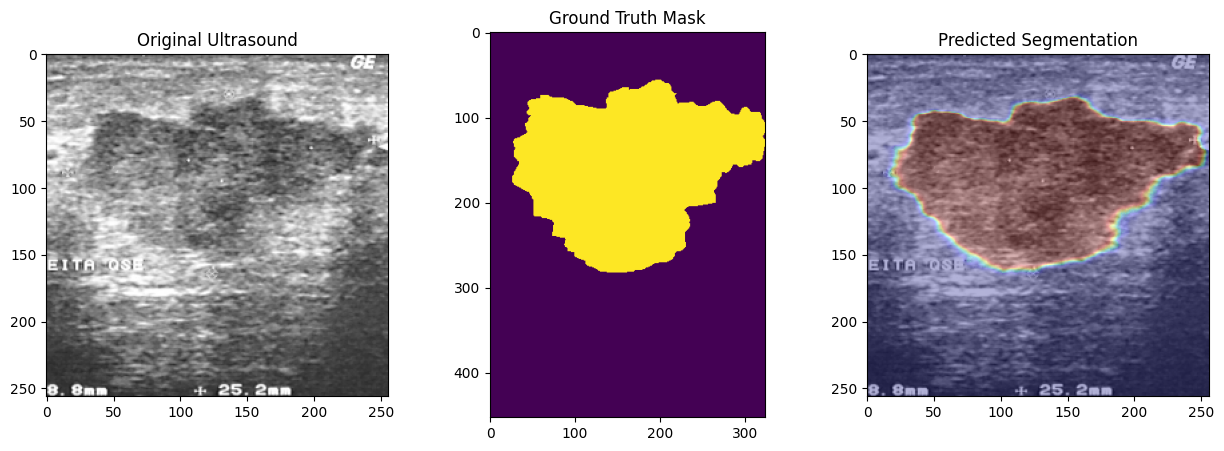

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


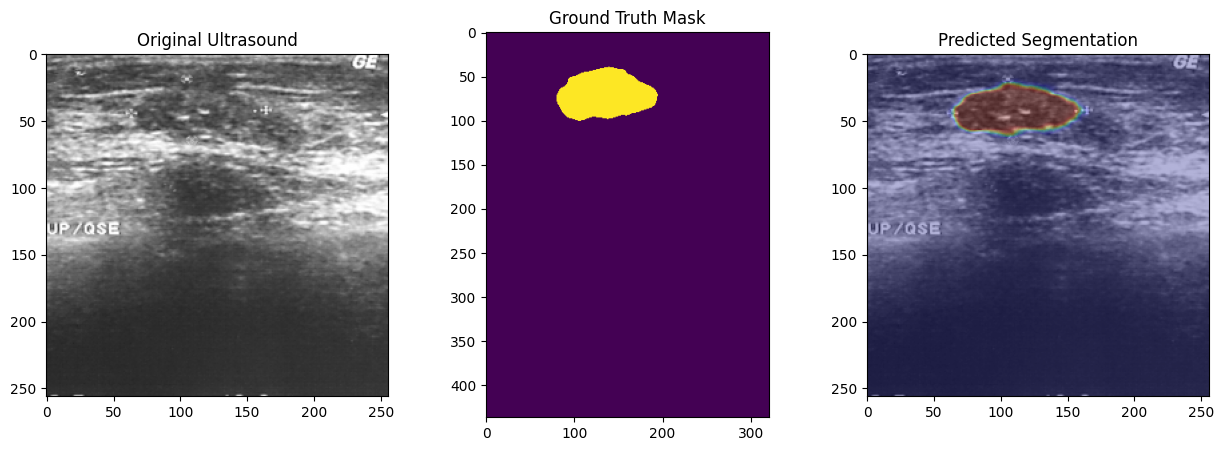

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


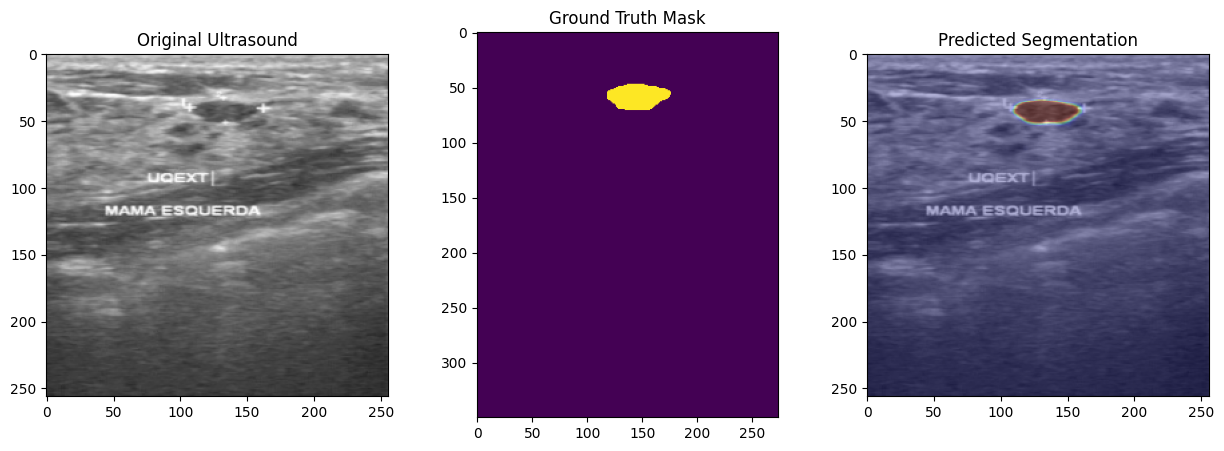

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


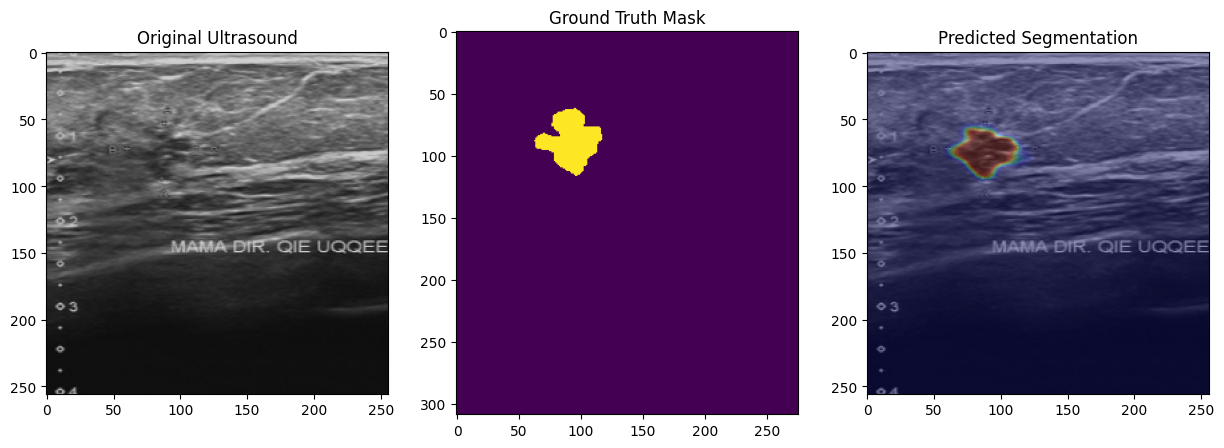

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


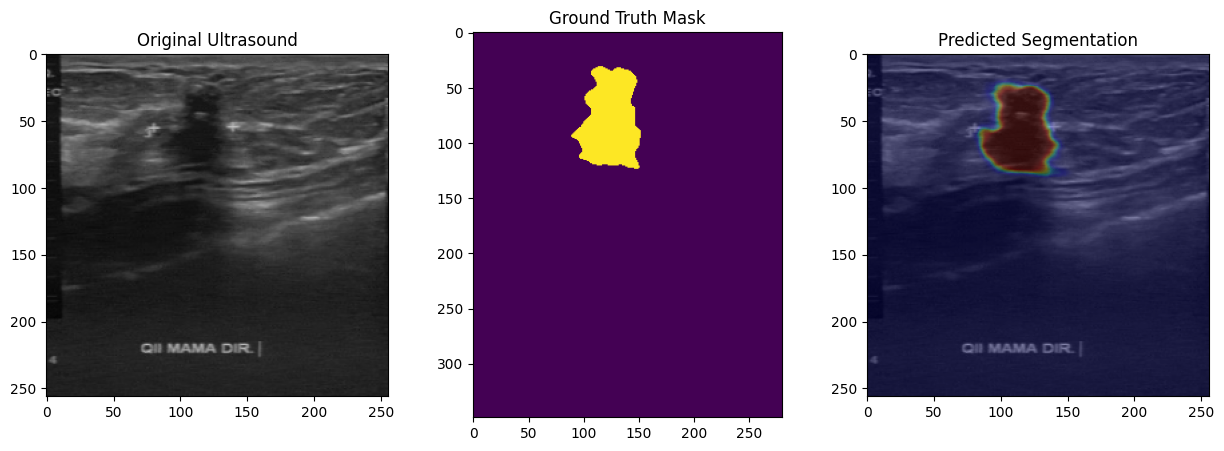

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


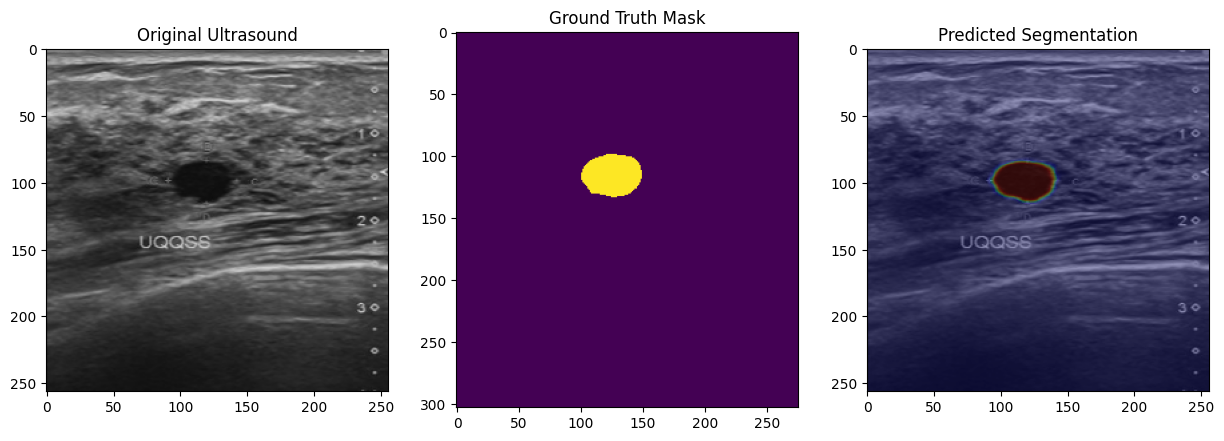

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


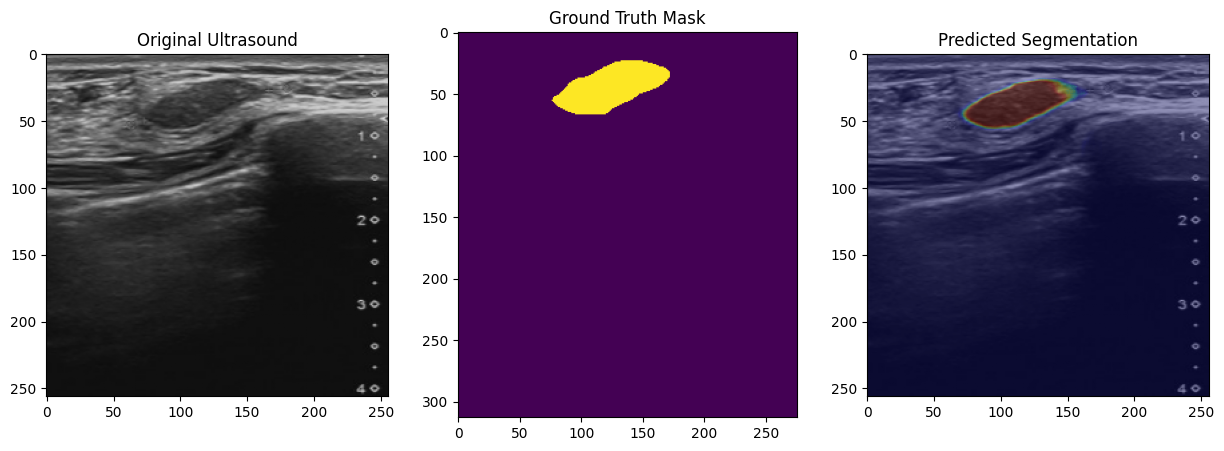

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


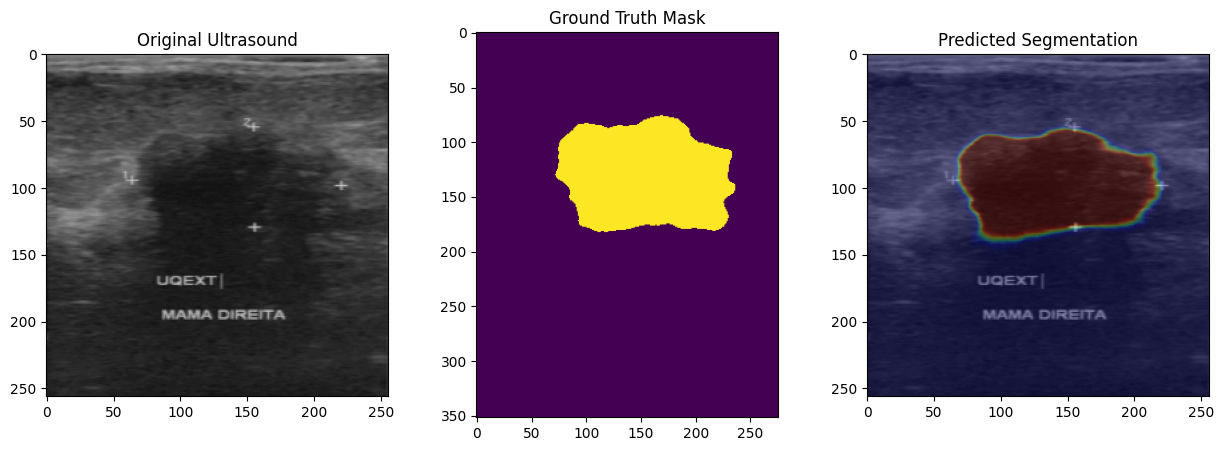

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


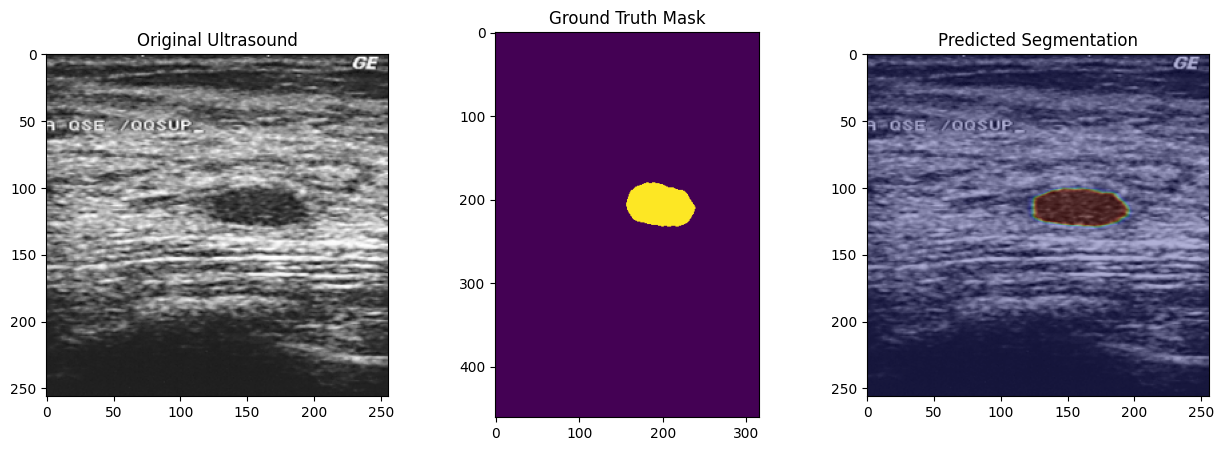

In [ ]:
for image_file in selected_images:
    image_path = os.path.join(image_dir, image_file)
    image_number = image_file.split("s")[1]
    mask_file = f"mask{image_number}"
    mask_path = os.path.join(mask_dir, mask_file)

    try:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Could not read image at path: {image_path}")
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256))

        true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if true_mask is None:
            print(f"Error: Could not read mask at path: {mask_path}")
            continue

        image = image[np.newaxis, ...] / 255.0

        pred_mask = unet_model.predict(image)
        true_mask = np.array(true_mask) / 255.0
        pred_mask = np.array(pred_mask) / 255.0
        true_mask = np.expand_dims(true_mask, axis = 0)
        pred_mask = np.expand_dims(pred_mask, axis = 0)


        visualize_segmentation(image, true_mask, pred_mask)

    except Exception as e:
        print(f"An error occurred while processing {image_file}: {e}")